# Part 1. Principles of Variational Inference

In variational inference, one wants to approximate the true posterior distribution $p(\omega | D)$ with a variational distribution $q_{\theta}(\omega)$. Variational parameters $\theta$ are chosen so that the "distance" between p and q is minimized.

One can use various notions of distance, for instance the KL divergence:
$$
KL (q || p) = E_{q}[\log{q(\omega)} - \log{p(\omega | D)}] = \int q(\omega) \log{\frac{q(\omega)}{p(\omega | D)}} d\omega
$$
<br>
or the alpha-divergence:
$$D_{\alpha}(p || q) = \frac{1}{\alpha (1-\alpha)} \left( 1-\int p(\omega)^{\alpha} q(\omega)^{1-\alpha} d\omega \right)$$
When $\alpha \rightarrow 0$, this is equivalent to the KL divergence.
<br>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Define the necessary distributions
def log_gaussian(omega, params):
    """univariate gaussian or independent gaussians"""
    mus = np.array(params[0:len(params)//2]).reshape((-1,))
    stds = np.array(params[len(params)//2:]).reshape((-1,))
    log2pi = np.log(2 * np.pi)
    log_gauss = 0
    for i in range(len(mus)):
        log_gauss += - 0.5*log2pi - np.log(stds[i]) - 0.5*((omega[:, i]-mus[i])/stds[i])**2
    return log_gauss
def gaussian(omega, params):
    return np.exp(log_gaussian(omega, params))

def univariate_gaussian_mixture(omega, mus, stds, pis):
    pdf = 0
    for i, pi in enumerate(pis):
        pdf += pi * gaussian(omega, [mus[i], stds[i]])
    return pdf

def log_bivariate_gaussian(omega, mu1, mu2, std1, std2, rho):
    z = ((omega[:,0]-mu1)/std1)**2 - 2*rho*(omega[:,0]-mu1)*(omega[:,1]-mu2)/(std1*std2) + ((omega[:,1]-mu2)/std2)**2
    log_term1 = -0.5*np.log(1-rho**2) - np.log(2 * np.pi * std1*std2)
    return log_term1 - 0.5 * z / (1-rho**2)
def bivariate_gaussian(omega, mu1, mu2, std1, std2, rho):
    return np.exp(log_bivariate_gaussian(omega, mu1, mu2, std1, std2, rho))

In [3]:
# Define distances, p is bimodal with fixed parameters, q is Gaussian
from scipy.integrate import quad, dblquad

# integrands for computation of KL divergence
def integrand_kl_1d(omega1, params_q, p, q, logq):
    omega = np.array(omega1).reshape((1,1))
    return q(omega, params_q) * (logq(omega, params_q) - np.log(p(omega)))
def integrand_kl_reverse_1d(omega1, params_q, p, q, logq):
    omega = np.array(omega1).reshape((1,1))
    return p(omega) * (np.log(p(omega)) - logq(omega, params_q))
def integrand_kl_2d(omega1, omega2, params_q, p, q, logq):
    omega = np.array([omega1, omega2]).reshape((1,2))
    return q(omega, params_q) * logq(omega, params_q) - q(omega, params_q) * np.log(p(omega))

# integrands for computation of alpha-divergence 
def integrand_alpha_1d(omega1, params_q, p, q, alpha):
    omega = np.array(omega1).reshape((1,1))
    return p(omega) ** alpha * q(omega, params_q) ** (1-alpha)
def integrand_alpha_2d(omega1, omega2, params_q, p, q, alpha):
    omega = np.array([omega1, omega2]).reshape((1,2))
    return p(omega) ** alpha * q(omega, params_q) ** (1-alpha)
    
# compute distance
def compute_distance(params_q, p, q, logq, alpha, dimension, distance_type):
    if dimension == 1:
        lb = -15.
        ub = 20.
    #if dimension == 1:
    #    lb = params_q[0]-3.5*params_q[1]
    #    ub = params_q[0]+3.5*params_q[1]
    elif dimension == 2:
        lb1 = params_q[0]-3.5*params_q[2]
        ub1 = params_q[0]+3.5*params_q[2]
        lb2 = params_q[1]-3.5*params_q[3]
        ub2 = params_q[1]+3.5*params_q[3]
    # KL divergence (requires logq)
    if 'kl' in distance_type.lower() and logq is None:
        logq = lambda omega, params: np.log(q(omega, params))
    if 'kl' == distance_type.lower() and dimension == 1:
        return quad(integrand_kl_1d, lb, ub, args=(params_q, p, q, logq))[0]
    elif 'kl' == distance_type.lower() and dimension == 2:
        return dblquad(integrand_kl_2d, lb2, ub2, lambda x: lb1, lambda x: ub1, args=(params_q, p, q, logq))[0]
    elif 'kl reverse' == distance_type.lower() and dimension == 1:
        return quad(integrand_kl_reverse_1d, lb, ub, args=(params_q, p, q, logq))[0]
    # alpha-divergence
    elif 'alpha' in distance_type.lower() and dimension == 1:
        return 1./(alpha*(1.-alpha))*(1. - quad(integrand_alpha_1d, lb, ub, args=(params_q, p, q, alpha))[0])
    elif 'alpha' in distance_type.lower() and dimension == 2:
        return 1./(alpha*(1.-alpha))*(1. - dblquad(
            integrand_alpha_2d, lb2, ub2, lambda x: lb1, lambda x: ub1, args=(params_q, p, q, alpha))[0])

In [4]:
# set optimization procedure to find parameters mu_q, std_q that minimize the distances
from scipy.optimize import minimize
def minimize_distance(p, q, distance_type, alpha=None, n_iter=5, bounds=None, logq=None, method='Nelder-Mead',
                      dimension=1, n_params_q=2, verbose=False):
    args = (p, q, logq, alpha, dimension, distance_type)
    fun_iters, params_iters = [], []
    for _ in range(n_iter):
        x0_ = np.concatenate([np.random.uniform(low=-5, high=5, size=(dimension, 1)), 
                                  np.random.uniform(low=0.1, high=2, size=(dimension, 1))], axis=0)
        res = minimize(compute_distance, args = args, x0=x0_, bounds=bounds, method=method, 
                       options={'disp': verbose, 'maxiter': 500, 'maxfev': 1000})
        fun_iters.append(res.fun)
        params_iters.append(res.x)
    ind = np.nanargmin(fun_iters)
    #print(fun_iters[ind])
    return params_iters[ind]

## p is univariate Gaussian

[-3.07390610e-06  1.20002065e+00]
[3.69707324e-05 1.19999871e+00]
[1.40705114e-05 1.19999172e+00]


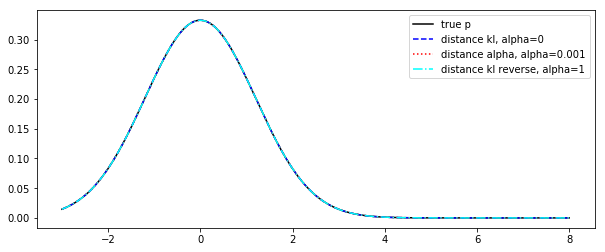

In [6]:
def gaussian_fixed(x):
    mu1=0; std1=1.2
    return gaussian(x, [mu1, std1])

fig, ax = plt.subplots(ncols=1, figsize=(10, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_fixed(x), label='true p', color='black')

distances = ['kl', 'alpha', 'kl reverse']
alphas = [0, 0.001, 1]
colors = ['blue', 'red', 'cyan']
linestyles = ['--', ':', '-.']
# run the optimization problem
for i in range(3):
    res = minimize_distance(p=gaussian_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=4, bounds=None, logq=log_gaussian, method='Nelder-Mead')
    ax.plot(x, gaussian(x, res), color=colors[i], linestyle=linestyles[i],
            label='distance ' + distances[i]+', alpha={}'.format(alphas[i]))
    print(res)
ax.legend()
plt.show(fig)

## Gaussian mixture

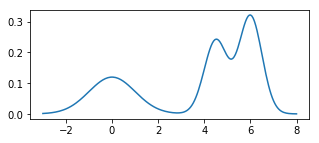

[5.30914348 0.8767437 ]
[5.31154818 0.88388434]
(2,)
(2,)


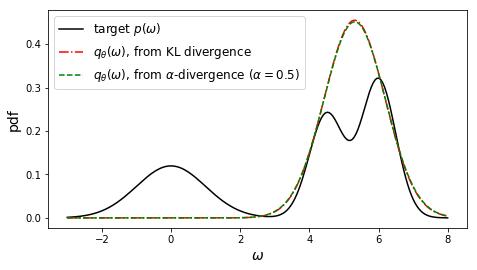

In [11]:
def gaussian_mixture_fixed(x):
    mu1=0; mu2=4.5; mu3=6; std1=1; std2=0.5; std3=0.5; pi1=0.3; pi2=0.3; pi3=0.4
    #mu1=2; mu2=4.5; std1=1; std2=0.5; pi1=0.6; pi2=0.4
    return univariate_gaussian_mixture(x, [mu1, mu2, mu3], [std1, std2, std3], [pi1, pi2, pi3])

fig, ax = plt.subplots(ncols=1, figsize=(5, 2))
x=np.linspace(-3, 8, 200).reshape((-1,1))
#ax.plot(x, gaussian(x, mu1, std1))
ax.plot(x, gaussian_mixture_fixed(x))
plt.show(fig)

distances = ['kl', 'alpha']
alphas = [0, 0.1]
# run the optimization problem
results_mix = []
for i in range(2):
    res = minimize_distance(p=gaussian_mixture_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=10, bounds=None, logq=log_gaussian, method='Nelder-Mead')
    results_mix.append(res)
    print(res)
    
titles = [r'$q_{\theta}(\omega)$, from KL divergence', 
          r'$q_{\theta}(\omega)$, from $\alpha$-divergence ($\alpha=0.5$)']
colors = ['red', 'green']
linestyles = ['-.', '--']

fig, ax = plt.subplots(ncols=1, figsize=(7.5, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_mixture_fixed(x), label=r'target $p(\omega)$', color='black')
for i in range(2):
    print(results_mix[i].shape)
    ax.plot(x, gaussian(x, results_mix[i]), color=colors[i], linestyle=linestyles[i], label=titles[i])
    ax.set_xlabel(r'$\omega$', fontsize=14); ax.set_ylabel('pdf', fontsize=14)
ax.legend(prop={'size': 12})
#plt.savefig('VI_example_1.pdf')
plt.show(fig)

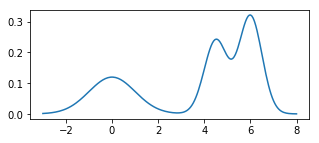

[5.30913495 0.87673758]
[5.30938107 0.87741415]
[3.74781087 2.62275327]
[3.75000841 2.62438958]
(2,)
(2,)
(2,)
(2,)


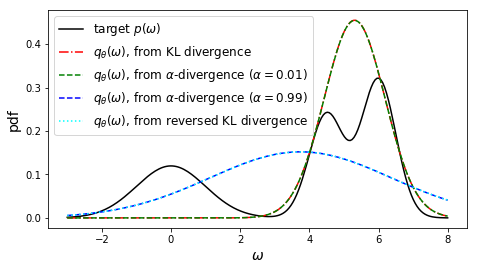

In [9]:
def gaussian_mixture_fixed(x):
    mu1=0; mu2=4.5; mu3=6; std1=1; std2=0.5; std3=0.5; pi1=0.3; pi2=0.3; pi3=0.4
    #mu1=2; mu2=4.5; std1=1; std2=0.5; pi1=0.6; pi2=0.4
    return univariate_gaussian_mixture(x, [mu1, mu2, mu3], [std1, std2, std3], [pi1, pi2, pi3])

fig, ax = plt.subplots(ncols=1, figsize=(5, 2))
x=np.linspace(-3, 8, 200).reshape((-1,1))
#ax.plot(x, gaussian(x, mu1, std1))
ax.plot(x, gaussian_mixture_fixed(x))
plt.show(fig)

distances = ['kl', 'alpha', 'alpha', 'kl reverse']
alphas = [0, 0.01, 0.99, 1]
# run the optimization problem
results_mix = []
for i in range(4):
    res = minimize_distance(p=gaussian_mixture_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=10, bounds=None, logq=log_gaussian, method='Nelder-Mead')
    results_mix.append(res)
    print(res)
    
titles = [r'$q_{\theta}(\omega)$, from KL divergence', 
          r'$q_{\theta}(\omega)$, from $\alpha$-divergence ($\alpha=0.01$)',
          r'$q_{\theta}(\omega)$, from $\alpha$-divergence ($\alpha=0.99$)',
         r'$q_{\theta}(\omega)$, from reversed KL divergence']
colors = ['red', 'green', 'blue', 'cyan']
linestyles = ['-.', '--', '--', ':']

fig, ax = plt.subplots(ncols=1, figsize=(7.5, 4))
x=np.linspace(-3, 8, 200).reshape((-1,1))
ax.plot(x, gaussian_mixture_fixed(x), label=r'target $p(\omega)$', color='black')
for i in range(4):
    print(results_mix[i].shape)
    ax.plot(x, gaussian(x, results_mix[i]), color=colors[i], linestyle=linestyles[i], label=titles[i])
    ax.set_xlabel(r'$\omega$', fontsize=14); ax.set_ylabel('pdf', fontsize=14)
ax.legend(prop={'size': 12})
plt.show(fig)

## Bivariate gaussian with correlation

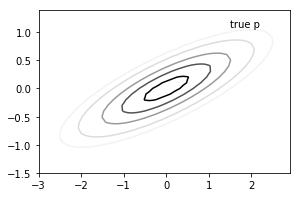

In [42]:
mu1=0; std1=1.2; mu2=0.; std2=0.5; rho=0.8
def gaussian_fixed(x):
    return bivariate_gaussian(x, mu1, mu2, std1, std2, rho)
fig, ax = plt.subplots(ncols=1, figsize=(4.5, 3))
x, y = np.mgrid[-3:3:.1, -1.5:1.5:.1]
X = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=-1)
ax.contour(x, y, gaussian_fixed(X).reshape(x.shape), 5, cmap='Greys', levels=[0.01, 0.05, 0.1, 0.2, 0.3, 0.4])
ax.text(s='true p', x=1.5, y=1.1)
plt.show()

In [44]:
distances = ['kl', 'alpha']
alphas = [None, 0.7]
# run the optimization problem
results = []
for i in range(2):
    res = minimize_distance(dimension=2, p=gaussian_fixed, q=gaussian, distance_type=distances[i], alpha=alphas[i], 
                            n_iter=1, bounds=None, logq=log_gaussian, method='Nelder-Mead', verbose=True)
    results.append(res)

/Users/audreyolivier/.conda/envs/UQ_in_ML/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


Optimization terminated successfully.
         Current function value: 0.510332
         Iterations: 193
         Function evaluations: 327
Optimization terminated successfully.
         Current function value: 0.533528
         Iterations: 169
         Function evaluations: 289


true params:
[0, 0.0, 1.2, 0.5]
params for distance kl, alpha=None
[-1.22003948e-04 -4.52385636e-05  7.22167435e-01  3.00936891e-01]
params for distance alpha, alpha=0.7
[-2.89640803e-05 -1.95367272e-06  1.06369091e+00  4.43209489e-01]


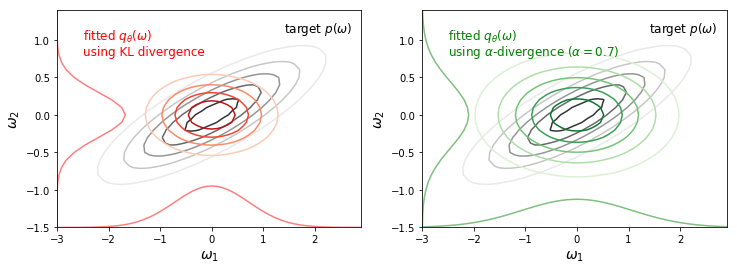

In [46]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
xx, yy = np.arange(-3, 3, .1), np.arange(-1.5, 1.5, .1)
x, y = np.mgrid[-3:3:.1, -1.5:1.5:.1]
X = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=-1)
for i in range(2):
    b = ax[i].contour(x, y, gaussian_fixed(X).reshape(x.shape), 5, cmap='Greys')

print('true params:')
print([mu1, mu2, std1, std2])

cmapss = ['Reds', 'Greens']
titles = [r'using KL divergence', 
          r'using $\alpha$-divergence ($\alpha=0.7$)']
colors = ['red', 'green']
for i in range(2):
    b = ax[i].contour(x, y, gaussian(X, results[i]).reshape(x.shape), 5, cmap=cmapss[i], 
                  #levels=[0.05, 0.1, 0.2, 0.3], vmin=0
                     )
    ax[i].set_xlabel(r'$\omega_{1}$', fontsize=14); ax[i].set_ylabel(r'$\omega_{2}$', fontsize=14)
    print('params for '+'distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(results[i])
    ax[i].text(s=r'target $p(\omega)$', x=1.4, y=1.1, fontsize=12)
    ax[i].text(s=r'fitted $q_{\theta}(\omega)$', x=-2.5, y=1.01, color=colors[i], fontsize=12)
    ax[i].text(s=titles[i], x=-2.5, y=0.8, color=colors[i], fontsize=12)
    
    ax[i].plot(xx, -1.5 + gaussian(xx.reshape((-1, 1)), np.array([results[i][0], results[i][2]])), 
               color=colors[i], alpha=0.5)
    ax[i].plot(-3. + gaussian(yy.reshape((-1, 1)), np.array([results[i][1], results[i][3]])), yy, 
               color=colors[i], alpha=0.5)
plt.savefig('VI_example_2.pdf')
plt.show(fig)

true params:
[0, 0.0, 1.2, 0.5]
params for distance kl, alpha=None
[-1.22003948e-04 -4.52385636e-05  7.22167435e-01  3.00936891e-01]
params for distance alpha, alpha=0.7
[-2.89640803e-05 -1.95367272e-06  1.06369091e+00  4.43209489e-01]


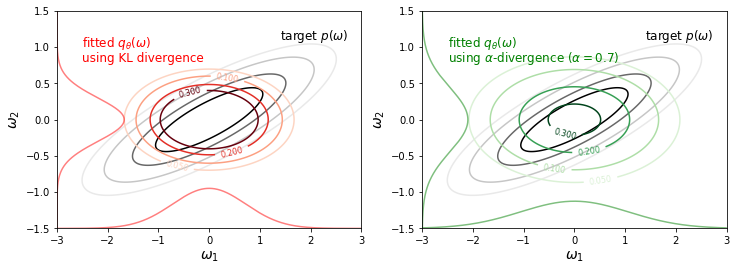

In [53]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))
xx, yy = np.arange(-3, 3, .01), np.arange(-1.5, 1.5, .01)
x, y = np.mgrid[-3:3:.001, -1.5:1.5:.001]
X = np.concatenate([x.reshape((-1,1)), y.reshape((-1,1))], axis=-1)
for i in range(2):
    b = ax[i].contour(x, y, gaussian_fixed(X).reshape(x.shape), 5, cmap='Greys', 
                  levels=[0.05, 0.1, 0.2, 0.3], vmin=0)
    #plt.clabel(b, inline=True, fontsize=8)

print('true params:')
print([mu1, mu2, std1, std2])

cmapss = ['Reds', 'Greens']
titles = [r'using KL divergence', 
          r'using $\alpha$-divergence ($\alpha=0.7$)']
colors = ['red', 'green']
for i in range(2):
    b = ax[i].contour(x, y, gaussian(X, results[i]).reshape(x.shape), 5, cmap=cmapss[i], 
                  levels=[0.05, 0.1, 0.2, 0.3], vmin=0)
    ax[i].set_xlabel(r'$\omega_{1}$', fontsize=14); ax[i].set_ylabel(r'$\omega_{2}$', fontsize=14)
    print('params for '+'distance '+distances[i]+', alpha={}'.format(alphas[i]))
    print(results[i])
    ax[i].text(s=r'target $p(\omega)$', x=1.4, y=1.1, fontsize=12)
    ax[i].text(s=r'fitted $q_{\theta}(\omega)$', x=-2.5, y=1.01, color=colors[i], fontsize=12)
    ax[i].text(s=titles[i], x=-2.5, y=0.8, color=colors[i], fontsize=12)
    
    ax[i].plot(xx, -1.5 + gaussian(xx.reshape((-1, 1)), np.array([results[i][0], results[i][2]])), 
               color=colors[i], alpha=0.5)
    ax[i].plot(-3. + gaussian(yy.reshape((-1, 1)), np.array([results[i][1], results[i][3]])), yy, 
               color=colors[i], alpha=0.5)
    plt.clabel(b, inline=True, fontsize=8)
plt.savefig('VI_example_2_revision1.pdf')
plt.show(fig)

# Part 2. VI algorithms on linear network (analytical solution exists)

The function is $y=\theta_{0} + \theta_{1} x_{1} + \theta_{2} x_{2} + \epsilon = X \theta + \epsilon$. The NN is composed simply of 2 inputs and 1 output, no hidden layer, and a linear activation function. The data is $D = \lbrace X, y \rbrace=\lbrace x_{1}, x_{2}, y\rbrace$.

The prior is chosen to be Gaussian, $p(\theta) = N(\cdot, \theta_{prior}, \Sigma_{prior})  $, and so is the noise $\epsilon \sim N(\cdot; 0, \sigma_{n}^{2} I)$. Then the posterior of the parameters can be computed analytically as:

\begin{align*}
& p(\theta \vert D={x,y}) =  N(\cdot; \theta_{post}(D), \Sigma_{post}(D)) \\
& \theta_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1} \left(\frac{1}{\sigma_{n}^{2}}X^{T}y+\Sigma^{-1}\theta_{prior} \right) \\
& \Sigma_{post}(D) = \left( \frac{1}{\sigma_{n}^{2}}X^{T}X + \Sigma_{prior}^{-1} \right)^{-1}
\end{align*}

In [2]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from UQ_in_ML.epistemic_regressors import BayesByBackprop, alphaBB

### Define some functions to compute the true posterior pdf from data, and some plotting utils

In [17]:
# compute the true posterior pdf based on available data
def compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n):
    X = np.concatenate([xn, np.ones((xn.shape[0], 1))], axis=1)
    
    # compute posterior pdf
    S_posterior = np.linalg.inv(1/var_n*np.matmul(X.T,X)+np.linalg.inv(S_prior))
    m_posterior = np.matmul(
        S_posterior, 
        1/var_n*np.matmul(X.T, yn)+np.matmul(np.linalg.inv(S_prior), m_prior.reshape((-1,1)))
        )
    m_posterior = m_posterior.reshape((-1,))
    return m_posterior, S_posterior

def compute_gaussian_pdf(x, mean, std):
    log2pi = np.log(2 * np.pi).astype(np.float32)
    return np.exp(- 0.5 * log2pi - np.log(std) - 0.5 * np.square(np.divide(np.subtract(x, mean), std)))

In [30]:
# plot the loss
def plot_loss(reg):
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(reg.loss_history)
    ax.set_xlabel('epochs'); ax.set_title('Loss convergence during training')
    plt.show(fig)

labels_params = [r'$W_{1}$', r'$W_{2}$', r'$b$']
# plot parameter learning
def plot_params_convergence(reg, m_posterior, S_posterior):
    fig, ax = plt.subplots(ncols=2, figsize=(13,4))
    for i in range(2):
        ax[0].plot(reg.variational_mu_history[0][:, i], label=labels_params[i]+', true={}'.format(m_posterior[i]))
        ax[1].plot(reg.variational_sigma_history[0][:, i], 
                   label=labels_params[i]+', true={}'.format(np.sqrt(np.diag(S_posterior)[i])))
    ax[0].plot(reg.variational_mu_history[1], label=labels_params[2]+', true={}'.format(m_posterior[2]))
    ax[1].plot(reg.variational_sigma_history[1], 
               label=labels_params[2]+', true={}'.format(np.sqrt(np.diag(S_posterior)[2])))
    ax[0].set_title('posterior mean')
    ax[1].set_title('posterior std')
    ax[0].grid('on'); ax[1].grid('on'); 
    ax[0].legend(); ax[1].legend()
    plt.show(fig)
    
def plot_marginals(m_posterior, S_posterior, vi_regressor, corrector_weights):
    print('Marginal pdfs in all dimensions')
    fig, ax = plt.subplots(ncols=3, figsize=(16, 4))
    for i in range(3):
        kwargs = {'color':'black', 'label':'true'}
        plot_univariate_pdf(mean=m_posterior[i], std=np.sqrt(S_posterior[i,i]), ax=ax[i], **kwargs)
        kwargs = {'color':'green', 'label':'VI regressor'}
        plot_univariate_pdf(mean=vi_regressor.variational_mu_history[-1, i], 
                            std=vi_regressor.variational_sigma_history[-1, i], 
                            ax=ax[i], **kwargs)
        kwargs = {'color':'red', 'label':'VI + correction'}
        plot_univariate_pdf(samples=corrector_weights[:, i], ax=ax[i], **kwargs)
    ax[0].legend()
    plt.show(fig)
    
# plot covariance and correlation matrices
def plot_corr(corrector_weights, S_posterior):
    print('Correlation matrix between parameters (left: true posterior, right: VI + IS corrector)')
    fig, ax = plt.subplots(ncols=2, figsize=(9, 3))
    plot_covariance_matrix(cov=cov_to_corr(S_posterior), ax=ax[0], labels=labels_params, type_cov='correlation')
    cov_post = np.cov(corrector_weights, rowvar=False)
    plot_covariance_matrix(cov=cov_to_corr(cov_post), ax=ax[1], labels=labels_params, type_cov='correlation')
    plt.show(fig)

## First problem: the posterior pdf is Gaussian with (almost) independent marginals

[ 1.05132619  1.60192765 -0.58301608]
[0.06007051 0.13579607 0.04504819]
[[ 0.00360847 -0.00161258 -0.00012921]
 [-0.00161258  0.01844057 -0.00065544]
 [-0.00012921 -0.00065544  0.00202934]]
rho = -0.10714446692167587


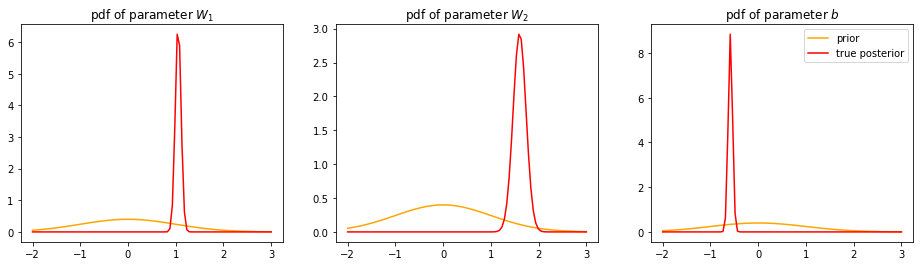

Correlation matrix between parameters (left: prior, right: posterior)


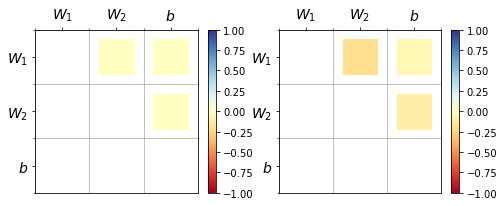

In [19]:
# define the problem
var_n = 0.1
w_true = [1., 1.7, -0.5]
f = lambda x, w, noisy: (w[0]*x[:, 0]+w[1]*x[:, 1]+w[2]).reshape((-1,1))+\
    noisy*np.random.normal(loc=0, scale=np.sqrt(var_n), size=(x.shape[0], 1))
    
n_data = 50
xn_ = np.random.uniform(low=0., high=10., size=(n_data, 1))
xn = np.concatenate([np.cos(xn_), 0.5*np.sin(xn_**2)], axis=1)
yn = f(xn, w_true, noisy = True)

m_prior = np.array([0, 0, 0])
S_prior = np.diag(np.array([1, 1, 1]))
m_posterior, S_posterior = compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n)
print(m_posterior)
print(np.sqrt(np.diag(S_posterior)))
print(S_posterior)
print('rho = {}'.format(S_posterior[1,2]/np.sqrt(S_posterior[1,1]*S_posterior[2,2])))
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
domain = np.linspace(-2,3,100)
for p in range(3):
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_prior[p], np.sqrt(np.diag(S_prior)[p])), 
               label='prior', color='orange')
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_posterior[p], np.sqrt(np.diag(S_posterior)[p])), 
               label='true posterior', color='red')
    ax[p].set_title('pdf of parameter '+labels_params[p])
ax[2].legend()
plt.show(fig)

print('Correlation matrix between parameters (left: prior, right: posterior)')
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
plot_covariance_matrix(cov=cov_to_corr(S_prior), ax=ax[0], labels=labels_params)
plot_covariance_matrix(cov=cov_to_corr(S_posterior), ax=ax[1], labels=labels_params)
plt.show(fig)

In [39]:
# define the network
hidden_units = () # no hidden layers
prior_params = (0., 1.) # only needed for output layer, for both kernels and biases
kwargs = {'hidden_units': hidden_units, 'input_dim': 2, 'output_dim': 1, 'var_n': var_n,
        'activation': None, 'weights_to_track': [2, 1], 'prior_means': 0., 'prior_stds': 1.}

In the following we test several algorihtms and look at the posterior pdf (in particular uncertainty on parameter p2 should be smaller than uncertainty on parameter p0).

### Test BayesByBackprop

Posterior results are correct.

In [34]:
reg = BayesByBackprop(analytical_grads=True, **kwargs)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=3000, lr=0.005)

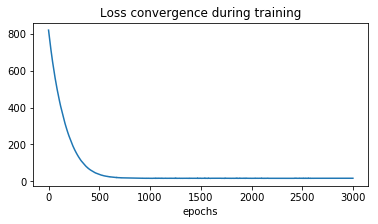

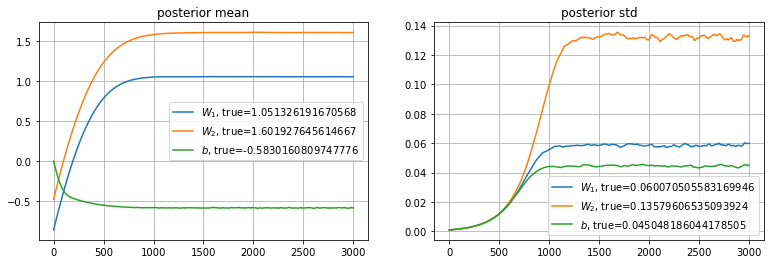

In [35]:
# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)

### Test alpha-BB algorithm

It overfits uncertainty with $\alpha=0.5$

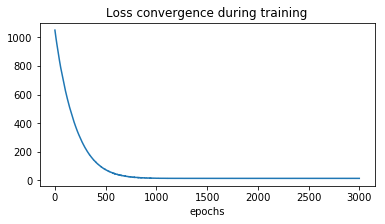

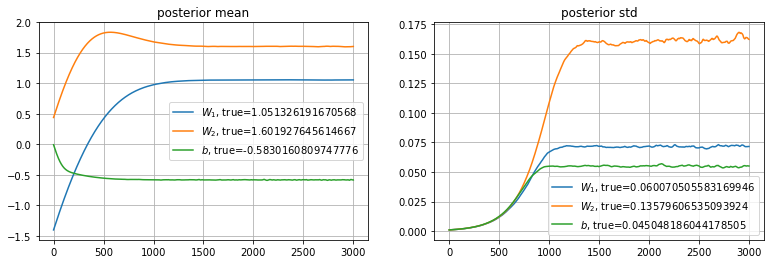

In [36]:
reg = alphaBB(**kwargs, alpha=0.5)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=3000, lr=0.005)
# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)

## Second problem: the posterior pdf is Gaussian with dependent marginals

[ 1.02094111  1.64607668 -0.4408011 ]
[0.04580772 0.06622007 0.09220994]
[[ 0.00209835 -0.00281697 -0.00069013]
 [-0.00281697  0.0043851  -0.00102008]
 [-0.00069013 -0.00102008  0.00850267]]


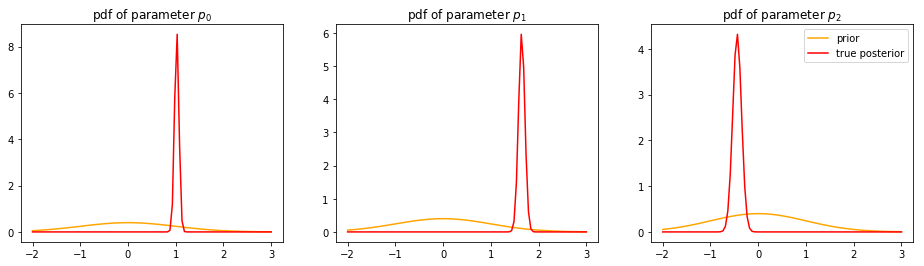

Correlation matrix between parameters (left: prior, right: posterior)


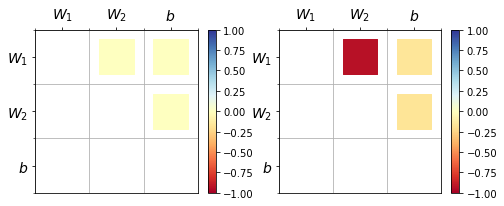

In [37]:
# define the problem
var_n = 0.1
w_true = [1., 1.7, -0.5]
f = lambda x, w, noisy: (w[0]*x[:, 0]+w[1]*x[:, 1]+w[2]).reshape((-1,1))+\
    noisy*np.random.normal(loc=0, scale=np.sqrt(var_n), size=(x.shape[0], 1))
    
n_data = 50
xn = np.random.uniform(low=0., high=10., size=(n_data, 1))
xn = np.concatenate([xn, 0.7*xn+np.sin(xn)], axis=1)
yn = f(xn, w_true, noisy = True)

m_prior = np.array([0, 0, 0])
S_prior = np.diag(np.array([1, 1, 1]))
m_posterior, S_posterior = compute_true_posterior_pdf(xn, yn, m_prior, S_prior, var_n)
print(m_posterior)
print(np.sqrt(np.diag(S_posterior)))
print(S_posterior)
fig, ax = plt.subplots(ncols=3, figsize=(16,4))
domain = np.linspace(-2,3,100)
for p in range(3):
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_prior[p], np.sqrt(np.diag(S_prior)[p])), 
               label='prior', color='orange')
    ax[p].plot(domain, compute_gaussian_pdf(domain, m_posterior[p], np.sqrt(np.diag(S_posterior)[p])), 
               label='true posterior', color='red')
    ax[p].set_title('pdf of parameter $p_{}$'.format(p))
ax[2].legend()
plt.show(fig)

print('Correlation matrix between parameters (left: prior, right: posterior)')
fig, ax = plt.subplots(ncols=2, figsize=(8, 3))
plot_covariance_matrix(cov=cov_to_corr(S_prior), ax=ax[0], labels=labels_params)
plot_covariance_matrix(cov=cov_to_corr(S_posterior), ax=ax[1], labels=labels_params)
plt.show(fig)

### BayesByBackprop

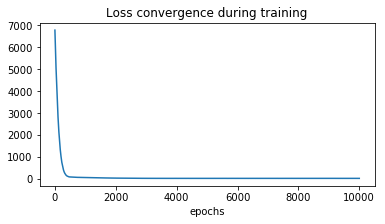

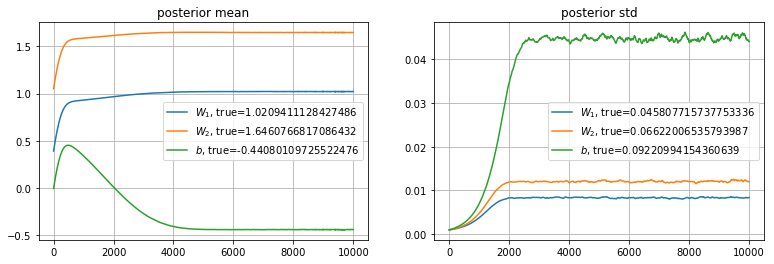

In [43]:
reg = BayesByBackprop(**kwargs)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=10000, lr=0.002)

# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)

### alpha BB algorithm

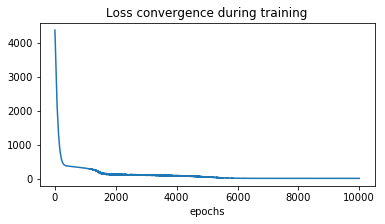

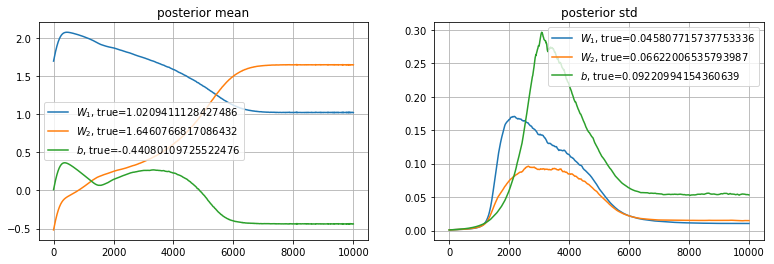

In [44]:
reg = alphaBB(**kwargs, alpha=0.5)
reg.fit(X=xn, y=yn, ns=40, verbose=False, epochs=10000, lr=0.002)

# plot the loss and parameter learning
plot_loss(reg)
plot_params_convergence(reg, m_posterior, S_posterior)